# Weighted ECM clustering vs Traditional ECM clustering
## With Seeds dataset


In [13]:
## Importing
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.wecm_new import wecm
from evclust.utils import ev_summary, ev_pcaplot, calculate_non_specificity, ev_plot_PCA, plotting
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from evclust.datasets import load_seeds


      A     B    D    E    F    G
0  15.0  15.0  6.0  3.0  2.0  5.0
1  15.0  15.0  6.0  3.0  1.0  5.0
2  14.0  14.0  5.0  3.0  3.0  5.0
3  14.0  14.0  5.0  3.0  2.0  5.0
4  16.0  15.0  6.0  4.0  1.0  5.0


D:\vtdo\projects\evclust\src\evclust\utils.py:1085: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_reduced[i, 0], data_reduced[i, 1], alpha=0.5, c=colors[i], marker=marker_list[i])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


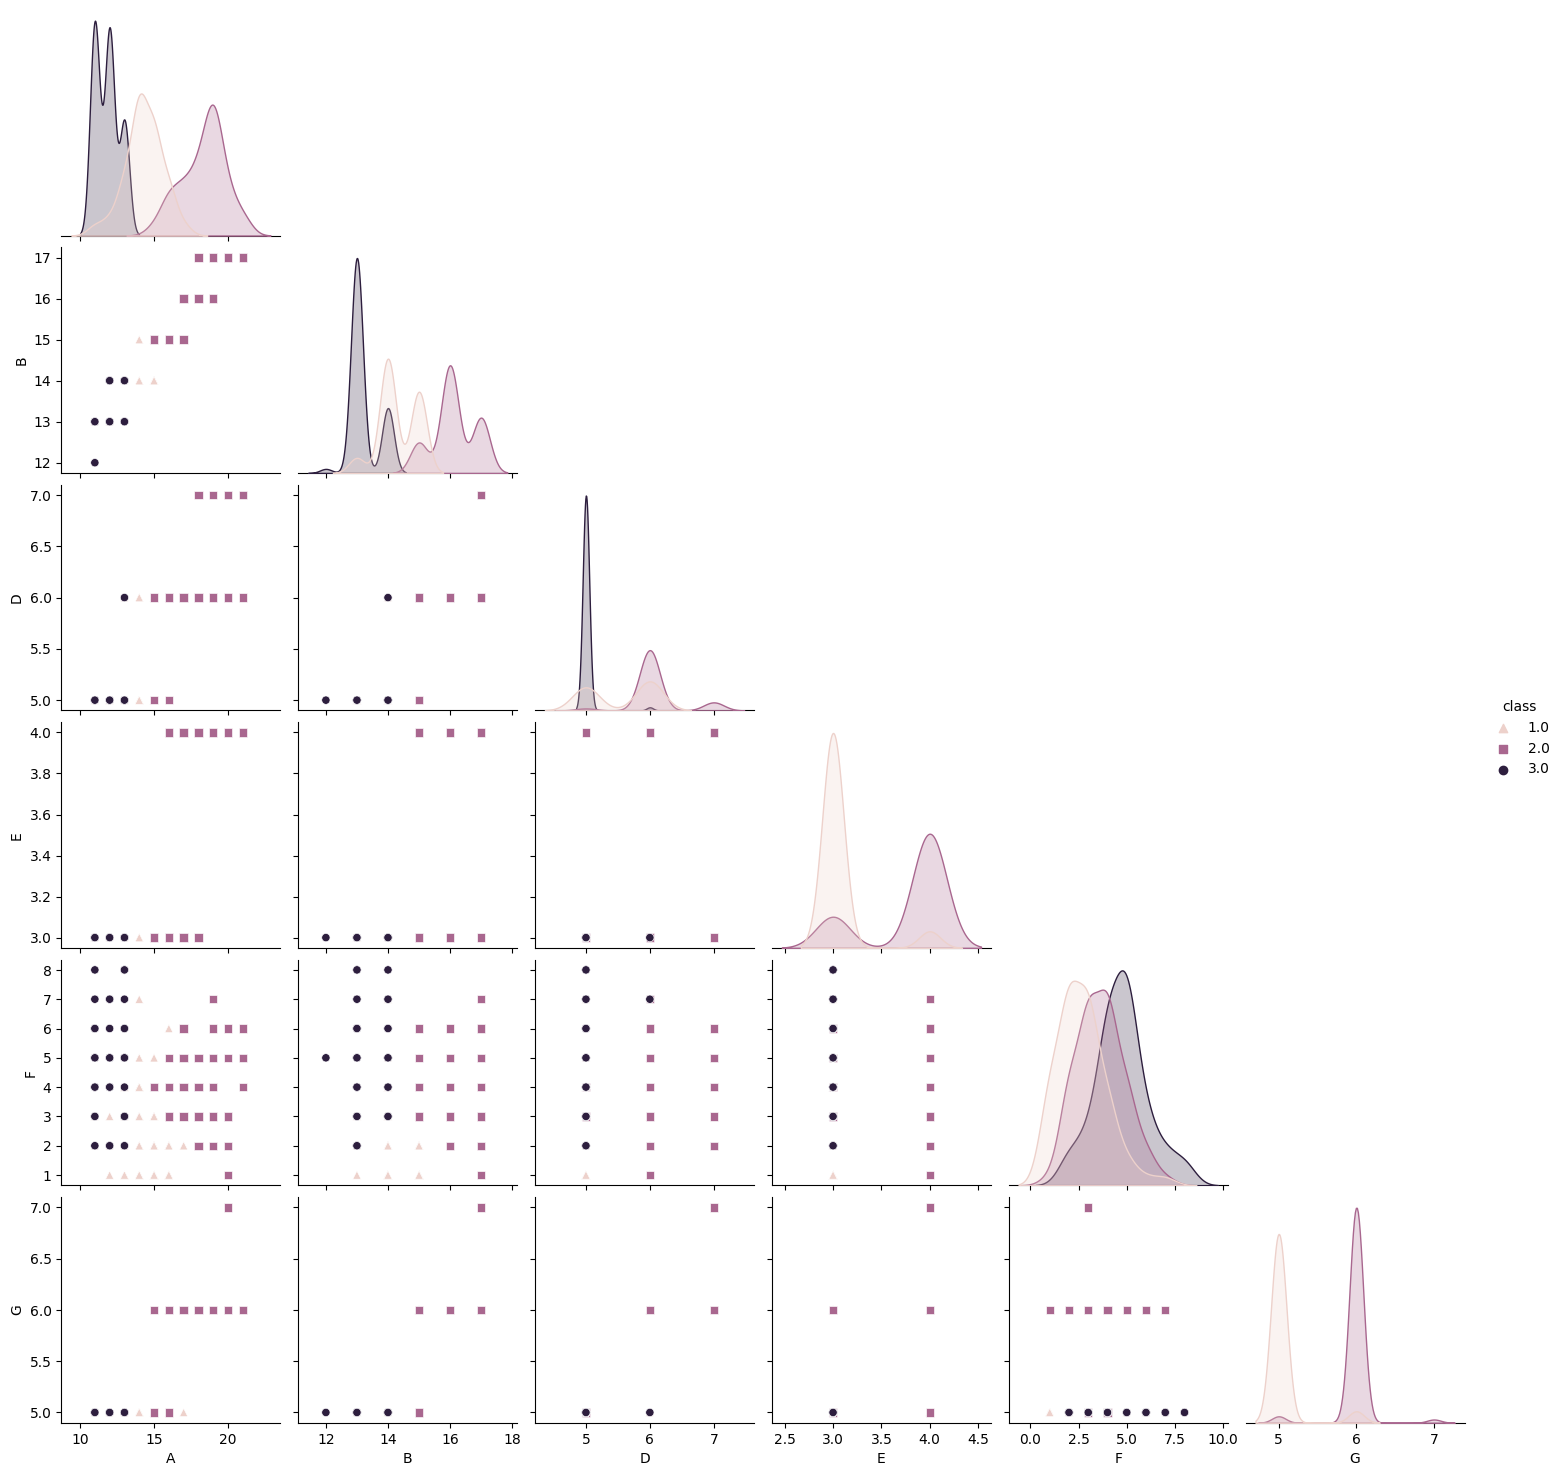

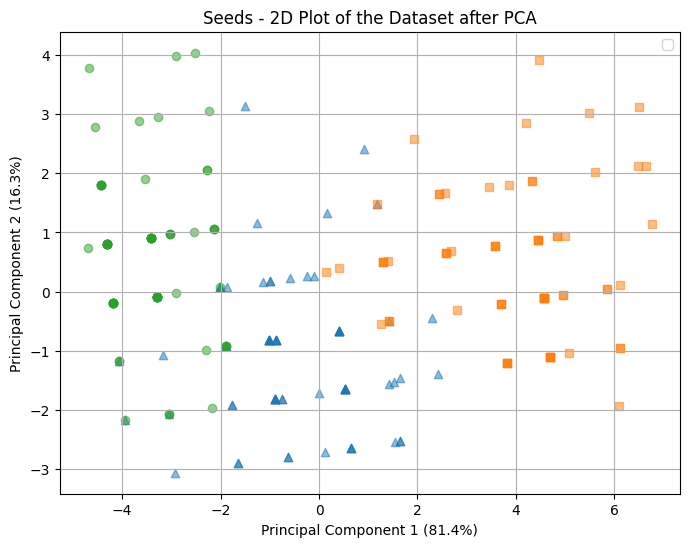

In [2]:
# fetch dataset
df = load_seeds()
df = df.drop(columns=['C'])  # all value equal 1
# data (as pandas dataframes)
y = pd.DataFrame(df.iloc[:, -1])
X = df.iloc[:, :-1]

label_column_nm = y.columns[0]
labels_encoder = LabelEncoder()
numeric_labels = labels_encoder.fit_transform(y[label_column_nm])

markers = ['^', 's', 'o']
plotting(X, y, ds_name="Seeds", matrix_plot=True, markers=markers)

# Normalization
scaler = MinMaxScaler((0,1))
X = pd.DataFrame(scaler.fit_transform(X))

## Traditional ECM

In [3]:
%%capture
# Traditional ECM clustering
delta = np.sqrt(20)
model_list = np.array([])
for i in range(10):
    model = ecm(x=X, c=3, beta=2, alpha=1, delta=delta, ntrials=10, init="non")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda x: x['crit'])
# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda model: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

J values: [10.650817980542984, 10.6508354950265, 10.650838696894098, 10.650845375357573, 10.650846847696368, 10.65084926358523, 10.650854854546921, 10.65086806453683, 10.65087612832227, 10.650886849481633]
ARI values: [0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245, 0.48551989606890245]
NS values: [1.1260054657184437, 0.990792835923867, 1.0903504218275881, 1.1268852686202375, 1.1259885931338387, 1.1257259666546426, 1.090338147162506, 0.9906175624927088, 1.090438275398713, 1.126225985685008]
NMI values: [0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186, 0.5240112233426186]
Average ARI values: 0.4855198960689025
Average Non-specificity: 1.0883368522617551
Average Normalized mutual infor: 0.5240112233426186


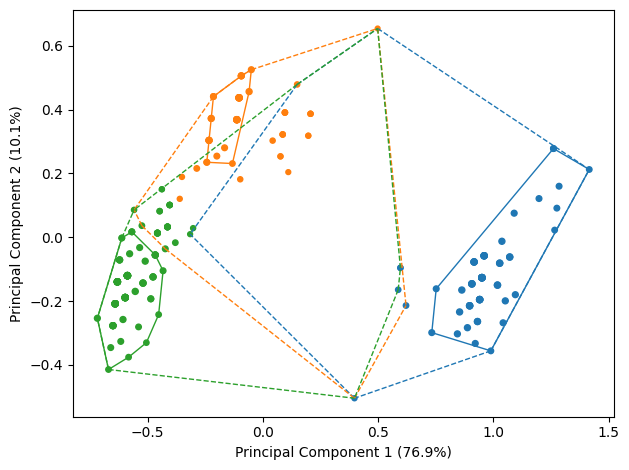

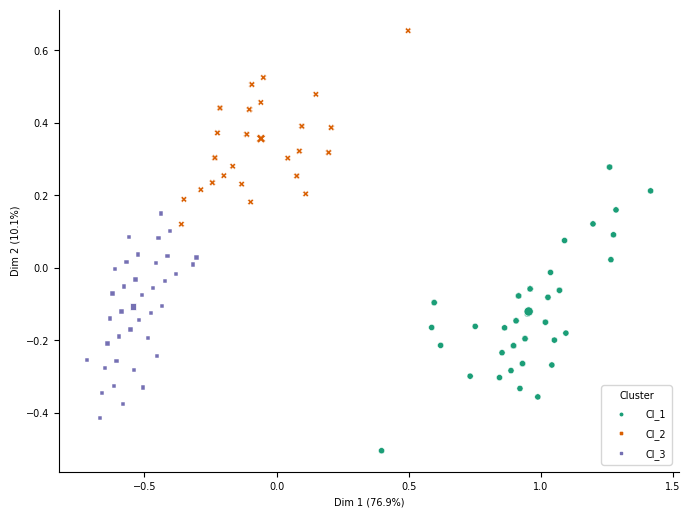

In [4]:

print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")

# Plotting the model with the minimum J value
ev_plot_PCA(model_list[0], X=X, cex=20)
ev_pcaplot(data=X, x=model_list[0], normalize=False, cex=20)

## Weighted ECM (W ECM)

In [10]:
%%capture
# Feature weighted ECM clustering
# W = np.array([
#     [0.07197209, 0.51605783, 0.11821111, 0.20893455, 0.01398744, 0.07083698],
#     [0.06738635, 0.02027021, 0.35386533, 0.02805789, 0.12012324, 0.41029698],
#     [0.0410078, 0.1919464, 0.01633889, 0.22999487, 0.18923781, 0.33147423]
# ])
model_list = np.array([])
c = 3
d = X.shape[1]
for i in range(10):
    # W = np.ones((c, d)) * (1 / d)
    W = None
    g0 = None
    delta = np.sqrt(20)
    model = wecm(x=X, c=c, g0=g0, W=W, beta=2, alpha=1, delta=delta, epsi=1e-3, ntrials=10, init="non")
    model_list = np.append(model_list, model)

model_list = sorted(model_list, key=lambda model: model['crit'])
# Weights
top_weights = [model['W'] for model in model_list]

# ARIs
true_labels = numeric_labels
predicted_labels_list = list(map(lambda model: np.argmax(model['betp'], axis=1), model_list))
ari_list = [adjusted_rand_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

# Non-specificity values of top 10
top_NS = [calculate_non_specificity(model, verbose=False) for model in model_list]

# Normalize mutual infor scores
NMIs = [normalized_mutual_info_score(true_labels, predicted_labels) for predicted_labels in predicted_labels_list]

In [11]:

print(f"J values: {[x['crit'] for x in model_list]}")
print(f"ARI values: {ari_list}")
print(f"NS values: {top_NS}")
print(f"NMI values: {NMIs}")
print(f"Average ARI values: {np.mean(ari_list)}")
print(f"Average Non-specificity: {np.mean(top_NS)}")
print(f"Average Normalized mutual infor: {np.mean(NMIs)}")

J values: [0.0031671633304816748, 0.005797085914101826, 0.009271676474215415, 0.012871693960218294, 0.012960983295296956, 0.013616016823195446, 0.01579946813917939, 0.038971663900999196, 0.050564640841154446, 0.0631405421654954]
ARI values: [0.5020571148398068, 0.5067839683309697, 0.5067839683309697, 0.5067839683309697, 0.5067839683309697, 0.49345077205217525, 0.5067839683309697, 0.46344784628258306, 0.46868321138518015, 0.5803808032222614]
NS values: [1.0796239848203617, 0.6835429697102402, 1.0003078097553824, 1.0019122869876553, 1.0013042496070623, 0.38080695570425266, 0.6908450428834334, 0.9996964364239147, 0.4654136693431748, 0.9149941246610472]
NMI values: [0.596539492396706, 0.5867834565097815, 0.5867834565097815, 0.5867834565097815, 0.5867834565097815, 0.571765499078075, 0.5867834565097815, 0.5478823009568651, 0.5859947544971288, 0.6231450123753208]
Average ARI values: 0.5041939589436855
Average Non-specificity: 0.8218447529896524
Average Normalized mutual infor: 0.5859244341853

In [12]:
for W in top_weights:
    print(f"\n{W}")


[[ 1.55282918e-01  2.35892557e-01  1.80774959e-01  7.31639511e-02
   1.04262271e-01  2.50623343e-01]
 [ 2.53017599e-02  2.91718807e-02  1.94950738e-02  6.56035931e-04
   1.32201214e-02  9.12155128e-01]
 [ 5.03462541e-03  5.11886005e-03  2.41708922e-03 -2.89931467e-03
   2.27957990e-03  9.88049160e-01]]

[[ 2.15338851e-02  2.57724193e-02  2.15549873e-02  2.11276097e-03
   1.23374545e-02  9.16688493e-01]
 [ 3.21450662e-01  4.40491049e-01  7.08032373e-02  1.35553244e-02
   1.12731359e-01  4.09683676e-02]
 [-3.67771134e-04 -3.54814434e-04 -1.75295523e-03  4.11769000e-01
   1.26673252e-03  5.89439809e-01]]

[[ 2.85552527e-01  3.08199427e-01  1.22064385e-01  1.75971399e-02
   2.19812333e-01  4.67741881e-02]
 [ 2.35811429e-02  2.81400091e-02  2.35316739e-02  1.32748447e-03
   1.36768334e-02  9.09742856e-01]
 [-4.93942037e-04 -1.91523311e-04  2.75465514e-03  3.70129646e-01
  -3.46802437e-03  6.31269189e-01]]

[[ 2.29960760e-01  2.80350000e-01  1.90555069e-01  2.34880935e-02
   1.92103788e-01 

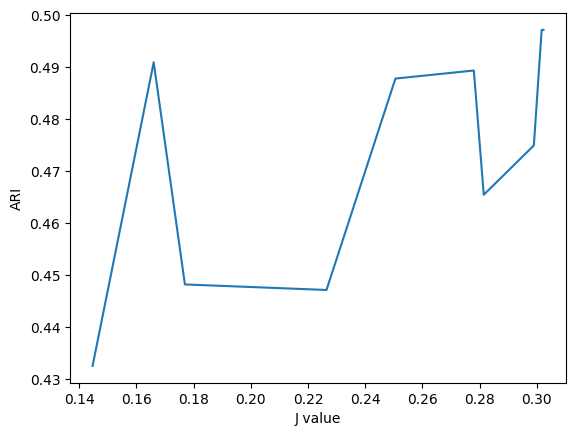

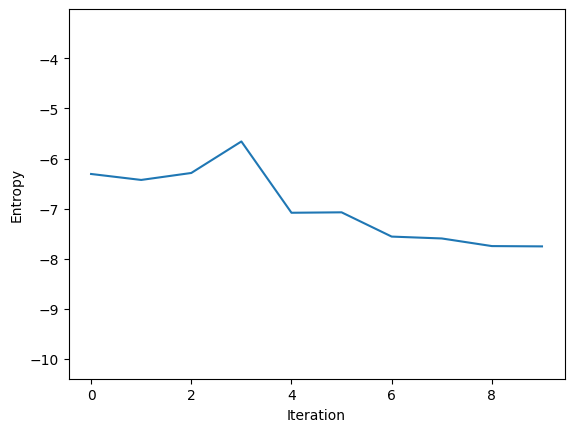

In [8]:
# J-ARI correlation chart
top_model_J = [model['crit'] for model in model_list]
plt.clf()
plt.plot(top_model_J, ari_list)
plt.xlabel("J value")
plt.ylabel("ARI")
plt.show()

entropy_list = [ np.sum( w * np.log2(w), axis=None) for w in top_weights]
print()
plt.clf()
plt.plot(entropy_list)
plt.xlabel("Iteration")
plt.ylabel("Entropy") 
plt.axis('equal')
plt.show()